In [ ]:
from datetime import datetime
import glob
import IPython
import os
import pickle
import PIL
import pprint
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torchinfo
import tqdm
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
torch.backends.cudnn.benchmark = True  # ループ内で順伝播や逆伝播が同じ計算手法ならば処理を高速化させる

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Pascal VOC 2012データを取得する
torchvision.datasets.VOCDetection(root="./data",  # データが有る場合は参照先、無い場合はダウンロード先
                                  year="2012",  # 取得するPascal VOCデータセットの年度
                                  image_set="val",  # 取得するPascal VOCデータセットの種別  # trainやtrainvalだとデータ数が多いのでvalのみにする
                                  download=True,  # 引数rootのディレクトリにデータが無い場合にダウンロードするかどうか
                                  transform=None,  # 取得時に画像データへ行う処理
                                  target_transform=None)  # 取得時にラベルデータへ行う処理

**Pascal VOC 2012データのvalのオリジナル画像とセグメント画像で教師データを準備**

In [ ]:
original_image_file_list = glob.glob("./data/VOCdevkit/VOC2012/JPEGImages/*.jpg")  # オリジナル画像のパスを全て取得
segment_image_file_list = glob.glob("./data/VOCdevkit/VOC2012/SegmentationClass/*.png")  # セグメント画像のパスを全て取得
original_image_PIL_list = []
segment_image_PIL_list = []
original_num_data = len(original_image_file_list)
segment_num_data = len(segment_image_file_list)
for i in range(segment_num_data):
    segment_image_file_name = segment_image_file_list[i][-15:-4]  # 1つ毎にセグメント画像のファイル名の番号部分を取得
    for j in range(original_num_data):
        original_image_file_name = original_image_file_list[j][-15:-4]  # 1つ毎にオリジナル画像のファイル名の番号部分を取得
        if original_image_file_name == segment_image_file_name:  # ファイル名の番号部分がオリジナル画像とセグメント画像で同じならば
            original_image_PIL = PIL.Image.open(original_image_file_list[j])  # 対象のオリジナル画像をPILへ変換
            segment_image_PIL = PIL.Image.open(segment_image_file_list[i])  # 対象のセグメント画像をPILへ変換
            original_image_PIL_list.append(original_image_PIL)  # PILに変換したオリジナル画像をリストに保管
            segment_image_PIL_list.append(segment_image_PIL)  # PILに変換したセグメント画像をリストに保管
        else:
            continue
print(len(original_image_PIL_list))
print(original_image_PIL_list[0])
IPython.display.display(original_image_PIL_list[0])  # 対応するオリジナル画像のPILを画像表示
print(len(segment_image_PIL_list))
print(segment_image_PIL_list[0])
IPython.display.display(segment_image_PIL_list[0])  # 対応するセグメント画像のPILを画像表示

**前処理(データ拡張含む)の準備**

In [ ]:
# 前処理で使うインスタンスを作成
image_transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224, 224))])  # 画像を224×224にサイズ変更

In [ ]:
# 前処理で使う関数(オリジナル画像は正規化してテンソル化、セグメント画像はテンソル化のみ)を作成
def normalize_and_tensorize(PIL_image, original_flag=True):
    if original_flag == True:  # オリジナル画像の場合
        image_array = np.array(PIL_image)  # PILをnumpyに変換(3階数テンソル)
        image_array = image_array.transpose(2, 0, 1)  # 形状を機械学習向けに変換
        normalize_image_array = image_array / 255  # RGBのダイレクトカラーなので255で割って値を正規化
        normalize_image_tensor = torch.FloatTensor(normalize_image_array)  # numpyをtensorに変換(FloatTensor)
        return normalize_image_tensor
    else:  # セグメント画像の場合
        image_array = np.array(PIL_image)  # PILをnumpyに変換(2階数行列)
        image_array = np.where(image_array==255, 21, image_array)  # 行列内で値が255のものは21へ変換、値が255以外のものはそのまま
        image_tensor = torch.LongTensor(image_array)  # numpyをtensorに変換(LongTensor)
        # image_tensor = image_tensor.unsqueeze(0)  # 2階数行列を3階数テンソルに変換
        return image_tensor

**前処理(dataset化やdataloader化含む)**

In [ ]:
# trainデータとvalidデータを、dataset化やdataloader化を踏まえてリストの形で作成
num_data = len(original_image_PIL_list)
train_original_image_PIL_list = original_image_PIL_list[:int(num_data*0.8)]  # 80%をtrainデータ(オリジナル画像)
valid_original_image_PIL_list = original_image_PIL_list[int(num_data*0.8):]  # 20%をvalidデータ(オリジナル画像)
train_segment_image_PIL_list = segment_image_PIL_list[:int(num_data*0.8)]  # 80%をtrainデータ(セグメント画像)
valid_segment_image_PIL_list = segment_image_PIL_list[int(num_data*0.8):]  # 20%をvalidデータ(セグメント画像)

In [ ]:
# Datasetクラスを作成
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, original_list, segment_list, image_transform_method, tensor_transform_method):
        super().__init__()  # 親クラスに__init__は無いので、これは無くても構わない(参考URL：https://r0w0.hatenablog.com/entry/2020/01/23/015941)
        self.original_list = original_list
        self.segment_list = segment_list
        self.image_transform_method = image_transform_method
        self.tensor_transform_method = tensor_transform_method

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, idx):
        original = self.original_list[idx]
        original_image_transform = self.image_transform_method(original)  # 画像サイズを変更
        original_image_transform_tensor = self.tensor_transform_method(PIL_image=original_image_transform, original_flag=True)  # 正規化とテンソル化
        segment = self.segment_list[idx]
        segment_image_transform = self.image_transform_method(segment)  # 画像サイズを変更
        segment_image_transform_tensor = self.tensor_transform_method(PIL_image=segment_image_transform, original_flag=False)  # テンソル化
        return original_image_transform_tensor, segment_image_transform_tensor

In [ ]:
# train、validデータをそれぞれdataset化
train_dataset = MyDataset(original_list=train_original_image_PIL_list,
                          segment_list=train_segment_image_PIL_list,
                          image_transform_method=image_transform,
                          tensor_transform_method=normalize_and_tensorize)
valid_dataset = MyDataset(original_list=valid_original_image_PIL_list,
                          segment_list=valid_segment_image_PIL_list,
                          image_transform_method=image_transform,
                          tensor_transform_method=normalize_and_tensorize)

In [ ]:
# train、validデータのdatasetをそれぞれdataloader化
train_dataset_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                       batch_size=7,
                                                       shuffle=False)
valid_dataset_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                       batch_size=7,
                                                       shuffle=False)

**U-Netモデルを作成<br>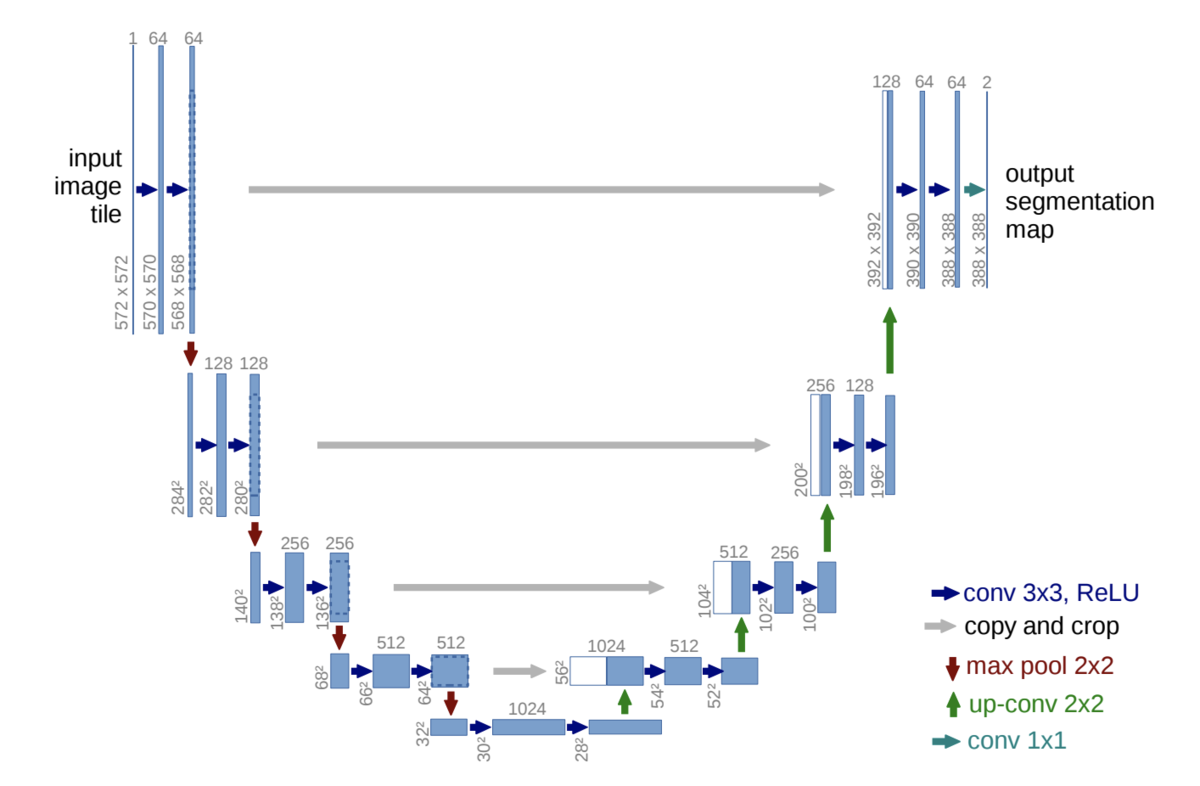**

In [ ]:
class MyUNetConvBlock(torch.nn.Module):
    def __init__(self, in_num, out_num):
        super().__init__()
        self.layer_1 = torch.nn.Conv2d(in_channels=in_num, out_channels=out_num, kernel_size=3, stride=1, padding=1)
        self.layer_2 = torch.nn.BatchNorm2d(num_features=out_num)
        self.layer_3 = torch.nn.ReLU()

    def forward(self, in_data):
        out_data_layer_1 = self.layer_1(in_data)
        out_data_layer_2 = self.layer_2(out_data_layer_1)
        out_data_layer_3 = self.layer_3(out_data_layer_2)
        return out_data_layer_3

In [ ]:
class MyUNetUpConvBlock(torch.nn.Module):
    def __init__(self, in_num, out_num):
        super().__init__()
        self.layer_1 = torch.nn.ConvTranspose2d(in_channels=in_num, out_channels=out_num, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.layer_2 = torch.nn.BatchNorm2d(num_features=out_num)
        self.layer_3 = torch.nn.ReLU()

    def forward(self, in_data):
        out_data_layer_1 = self.layer_1(in_data)
        out_data_layer_2 = self.layer_2(out_data_layer_1)
        out_data_layer_3 = self.layer_3(out_data_layer_2)
        return out_data_layer_3

In [ ]:
class MyUNet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.layer_1a_encoder = MyUNetConvBlock(in_num=in_dim, out_num=hid_dim)  # 畳み込み層(入力)
        self.layer_1b_encoder = MyUNetConvBlock(in_num=hid_dim, out_num=hid_dim)  # 畳み込み層
        self.layer_1c_encoder = MyUNetConvBlock(in_num=hid_dim, out_num=hid_dim)  # 畳み込み層
        self.layer_1_to_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # ダウンサンプリング層(解像度を半分)
        self.layer_2a_encoder = MyUNetConvBlock(in_num=hid_dim, out_num=hid_dim*2)  # 畳み込み層
        self.layer_2b_encoder = MyUNetConvBlock(in_num=hid_dim*2, out_num=hid_dim*2)  # 畳み込み層
        self.layer_2c_encoder = MyUNetConvBlock(in_num=hid_dim*2, out_num=hid_dim*2)  # 畳み込み層
        self.layer_2_to_3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # ダウンサンプリング層(解像度を半分)
        self.layer_3a_encoder = MyUNetConvBlock(in_num=hid_dim*2, out_num=hid_dim*4)  # 畳み込み層
        self.layer_3b_encoder = MyUNetConvBlock(in_num=hid_dim*4, out_num=hid_dim*4)  # 畳み込み層
        self.layer_3c_encoder = MyUNetConvBlock(in_num=hid_dim*4, out_num=hid_dim*4)  # 畳み込み層
        self.layer_3_to_4 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # ダウンサンプリング層(解像度を半分)
        self.layer_4a_encoder = MyUNetConvBlock(in_num=hid_dim*4, out_num=hid_dim*8)  # 畳み込み層
        self.layer_4b_encoder = MyUNetConvBlock(in_num=hid_dim*8, out_num=hid_dim*8)  # 畳み込み層
        self.layer_4c_encoder = MyUNetConvBlock(in_num=hid_dim*8, out_num=hid_dim*8)  # 畳み込み層
        self.layer_4_to_5 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # ダウンサンプリング層(解像度を半分)
        self.layer_5a_bridge = MyUNetConvBlock(in_num=hid_dim*8, out_num=hid_dim*16)  # 畳み込み層
        self.layer_5b_bridge = MyUNetConvBlock(in_num=hid_dim*16, out_num=hid_dim*16)  # 畳み込み層
        self.layer_5c_bridge = MyUNetConvBlock(in_num=hid_dim*16, out_num=hid_dim*16)  # 畳み込み層
        self.layer_5_to_6 = MyUNetUpConvBlock(in_num=hid_dim*16, out_num=hid_dim*8)  # アップサンプリング層(チャンネルを半分、解像度を2倍)
        self.layer_6a_decoder = MyUNetConvBlock(in_num=hid_dim*16, out_num=hid_dim*8)  # 畳み込み層(入力はskip-connection有り)
        self.layer_6b_decoder = MyUNetConvBlock(in_num=hid_dim*8, out_num=hid_dim*8)  # 畳み込み層
        self.layer_6c_decoder = MyUNetConvBlock(in_num=hid_dim*8, out_num=hid_dim*8)  # 畳み込み層
        self.layer_6_to_7 = MyUNetUpConvBlock(in_num=hid_dim*8, out_num=hid_dim*4)  # アップサンプリング層(チャンネルを半分、解像度を2倍)
        self.layer_7a_decoder = MyUNetConvBlock(in_num=hid_dim*8, out_num=hid_dim*4)  # 畳み込み層(入力はskip-connection有り)
        self.layer_7b_decoder = MyUNetConvBlock(in_num=hid_dim*4, out_num=hid_dim*4)  # 畳み込み層
        self.layer_7c_decoder = MyUNetConvBlock(in_num=hid_dim*4, out_num=hid_dim*4)  # 畳み込み層
        self.layer_7_to_8 = MyUNetUpConvBlock(in_num=hid_dim*4, out_num=hid_dim*2)  # アップサンプリング層(チャンネルを半分、解像度を2倍)
        self.layer_8a_decoder = MyUNetConvBlock(in_num=hid_dim*4, out_num=hid_dim*2)  # 畳み込み層(入力はskip-connection有り)
        self.layer_8b_decoder = MyUNetConvBlock(in_num=hid_dim*2, out_num=hid_dim*2)  # 畳み込み層
        self.layer_8c_decoder = MyUNetConvBlock(in_num=hid_dim*2, out_num=hid_dim*2)  # 畳み込み層
        self.layer_8_to_9 = MyUNetUpConvBlock(in_num=hid_dim*2, out_num=hid_dim)  # アップサンプリング層(チャンネルを半分、解像度を2倍)
        self.layer_9a_decoder = MyUNetConvBlock(in_num=hid_dim*2, out_num=hid_dim)  # 畳み込み層(入力はskip-connection有り)
        self.layer_9b_decoder = MyUNetConvBlock(in_num=hid_dim, out_num=hid_dim)  # 畳み込み層
        self.layer_9c_decoder = MyUNetConvBlock(in_num=hid_dim, out_num=hid_dim)  # 畳み込み層
        self.layer_9d_decoder = torch.nn.Conv2d(in_channels=hid_dim, out_channels=out_dim, kernel_size=3, stride=1, padding=1)  # 畳み込み層(出力)

    def forward(self, in_data):
        # print("入力：", in_data.shape)  # (ミニバッチ数, チャンネル数, 縦, 横) # torch.Size([7, 3, 224, 224])
        out_data_layer_1a_encoder = self.layer_1a_encoder(in_data)
        # print("1a：", out_data_layer_1a_encoder.shape)  # torch.Size([7, 64, 224, 224])
        out_data_layer_1b_encoder = self.layer_1b_encoder(out_data_layer_1a_encoder)
        # print("1b：", out_data_layer_1b_encoder.shape)  # torch.Size([7, 64, 224, 224])
        out_data_layer_1c_encoder = self.layer_1c_encoder(out_data_layer_1b_encoder)
        # print("1c：", out_data_layer_1c_encoder.shape)  # torch.Size([7, 64, 224, 224])
        out_data_layer_1_to_2 = self.layer_1_to_2(out_data_layer_1c_encoder)
        # print("1to2：", out_data_layer_1_to_2.shape)  # torch.Size([7, 64, 112, 112])
        out_data_layer_2a_encoder = self.layer_2a_encoder(out_data_layer_1_to_2)
        # print("2a：", out_data_layer_2a_encoder.shape)  # torch.Size([7, 128, 112, 112])
        out_data_layer_2b_encoder = self.layer_2b_encoder(out_data_layer_2a_encoder)
        # print("2b：", out_data_layer_2b_encoder.shape)  # torch.Size([7, 128, 112, 112])
        out_data_layer_2c_encoder = self.layer_2c_encoder(out_data_layer_2b_encoder)
        # print("2c：", out_data_layer_2c_encoder.shape)  # torch.Size([7, 128, 112, 112])
        out_data_layer_2_to_3 = self.layer_2_to_3(out_data_layer_2c_encoder)
        # print("2to3：", out_data_layer_2_to_3.shape)  # torch.Size([7, 128, 56, 56])
        out_data_layer_3a_encoder = self.layer_3a_encoder(out_data_layer_2_to_3)
        # print("3a：", out_data_layer_3a_encoder.shape)  # torch.Size([7, 256, 56, 56])
        out_data_layer_3b_encoder = self.layer_3b_encoder(out_data_layer_3a_encoder)
        # print("3b：", out_data_layer_3b_encoder.shape)  # torch.Size([7, 256, 56, 56])
        out_data_layer_3c_encoder = self.layer_3c_encoder(out_data_layer_3b_encoder)
        # print("3c：", out_data_layer_3c_encoder.shape)  # torch.Size([7, 256, 56, 56])
        out_data_layer_3_to_4 = self.layer_3_to_4(out_data_layer_3c_encoder)
        # print("3to4：", out_data_layer_3_to_4.shape)  # torch.Size([7, 256, 28, 28])
        out_data_layer_4a_encoder = self.layer_4a_encoder(out_data_layer_3_to_4)
        # print("4a：", out_data_layer_4a_encoder.shape)  # torch.Size([7, 512, 28, 28])
        out_data_layer_4b_encoder = self.layer_4b_encoder(out_data_layer_4a_encoder)
        # print("4b：", out_data_layer_4b_encoder.shape)  # torch.Size([7, 512, 28, 28])
        out_data_layer_4c_encoder = self.layer_4c_encoder(out_data_layer_4b_encoder)
        # print("4c：", out_data_layer_4c_encoder.shape)  # torch.Size([7, 512, 28, 28])
        out_data_layer_4_to_5 = self.layer_4_to_5(out_data_layer_4c_encoder)
        # print("4to5：", out_data_layer_4_to_5.shape)  # torch.Size([7, 512, 14, 14])
        out_data_layer_5a_bridge = self.layer_5a_bridge(out_data_layer_4_to_5)
        # print("5a：", out_data_layer_5a_bridge.shape)  # torch.Size([7, 1024, 14, 14])
        out_data_layer_5b_bridge = self.layer_5b_bridge(out_data_layer_5a_bridge)
        # print("5b：", out_data_layer_5b_bridge.shape)  # torch.Size([7, 1024, 14, 14])
        out_data_layer_5c_bridge = self.layer_5c_bridge(out_data_layer_5b_bridge)
        # print("5c：", out_data_layer_5c_bridge.shape)  # torch.Size([7, 1024, 14, 14])
        out_data_layer_5_to_6 = self.layer_5_to_6(out_data_layer_5c_bridge)
        # print("5to6：", out_data_layer_5_to_6.shape)  # torch.Size([7, 512, 28, 28])
        in_data_layer_6a_decoder = torch.cat([out_data_layer_5_to_6, out_data_layer_4c_encoder], dim=1)  # (ミニバッチ, チャンネル, 縦, 横)でチャンネル方向にコンカチなのでdim=1
        # print("in6a：", in_data_layer_6a_decoder.shape)  # torch.Size([7, 1024, 28, 28])
        out_data_layer_6a_decoder = self.layer_6a_decoder(in_data_layer_6a_decoder)
        # print("6a：", out_data_layer_6a_decoder.shape)  # torch.Size([7, 512, 28, 28])
        out_data_layer_6b_decoder = self.layer_6b_decoder(out_data_layer_6a_decoder)
        # print("6b：", out_data_layer_6b_decoder.shape)  # torch.Size([7, 512, 28, 28])
        out_data_layer_6c_decoder = self.layer_6c_decoder(out_data_layer_6b_decoder)
        # print("6c：", out_data_layer_6c_decoder.shape)  # torch.Size([7, 512, 28, 28])
        out_data_layer_6_to_7 = self.layer_6_to_7(out_data_layer_6c_decoder)
        # print("6to7：", out_data_layer_6_to_7.shape)  # torch.Size([7, 256, 56, 56])
        in_data_layer_7a_decoder = torch.cat([out_data_layer_6_to_7, out_data_layer_3c_encoder], dim=1)
        # print("in7a：", in_data_layer_7a_decoder.shape)  # torch.Size([7, 512, 56, 56])
        out_data_layer_7a_decoder = self.layer_7a_decoder(in_data_layer_7a_decoder)
        # print("7a：", out_data_layer_7a_decoder.shape)  # torch.Size([7, 256, 56, 56])
        out_data_layer_7b_decoder = self.layer_7b_decoder(out_data_layer_7a_decoder)
        # print("7b：", out_data_layer_7b_decoder.shape)  # torch.Size([7, 256, 56, 56])
        out_data_layer_7c_decoder = self.layer_7c_decoder(out_data_layer_7b_decoder)
        # print("7c：", out_data_layer_7c_decoder.shape)  # torch.Size([7, 256, 56, 56])
        out_data_layer_7_to_8 = self.layer_7_to_8(out_data_layer_7c_decoder)
        # print("7to8：", out_data_layer_7_to_8.shape)  # torch.Size([7, 128, 112, 112])
        in_data_layer_8a_decoder = torch.cat([out_data_layer_7_to_8, out_data_layer_2c_encoder], dim=1)
        # print("in8a：", in_data_layer_8a_decoder.shape)  # torch.Size([7, 256, 112, 112])
        out_data_layer_8a_decoder = self.layer_8a_decoder(in_data_layer_8a_decoder)
        # print("8a：", out_data_layer_8a_decoder.shape)  # torch.Size([7, 128, 112, 112])
        out_data_layer_8b_decoder = self.layer_8b_decoder(out_data_layer_8a_decoder)
        # print("8b：", out_data_layer_8b_decoder.shape)  # torch.Size([7, 128, 112, 112])
        out_data_layer_8c_decoder = self.layer_8c_decoder(out_data_layer_8b_decoder)
        # print("8c：", out_data_layer_8c_decoder.shape)  # torch.Size([7, 128, 112, 112])
        out_data_layer_8_to_9 = self.layer_8_to_9(out_data_layer_8c_decoder)
        # print("8to9：", out_data_layer_8_to_9.shape)  # torch.Size([7, 64, 224, 224])
        in_data_layer_9a_decoder = torch.cat([out_data_layer_8_to_9, out_data_layer_1c_encoder], dim=1)
        # print("in9a：", in_data_layer_9a_decoder.shape)  # torch.Size([7, 128, 224, 224])
        out_data_layer_9a_decoder = self.layer_9a_decoder(in_data_layer_9a_decoder)
        # print("9a：", out_data_layer_9a_decoder.shape)  # torch.Size([7, 64, 224, 224])
        out_data_layer_9b_decoder = self.layer_9b_decoder(out_data_layer_9a_decoder)
        # print("9b：", out_data_layer_9b_decoder.shape)  # torch.Size([7, 64, 224, 224])
        out_data_layer_9c_decoder = self.layer_9c_decoder(out_data_layer_9b_decoder)
        # print("9c：", out_data_layer_9c_decoder.shape)  # torch.Size([7, 64, 224, 224])
        out_data_layer_9d_decoder = self.layer_9d_decoder(out_data_layer_9c_decoder)
        # print("9d：", out_data_layer_9d_decoder.shape)  # torch.Size([7, 22, 224, 224])
        return out_data_layer_9d_decoder

**モデル、損失関数、最適化アルゴリズム**

In [ ]:
nn_model = MyUNet(in_dim=3,
                  hid_dim=64,
                  out_dim=22).to(device)  # GPUへ
loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(),
                             lr=0.001)

In [ ]:
torchinfo.summary(nn_model,
                  input_size=(7, 3, 224, 224),
                  depth=5)

Layer (type:depth-idx)                   Output Shape              Param #
MyUNet                                   [7, 22, 224, 224]         --
├─MyUNetConvBlock: 1-1                   [7, 64, 224, 224]         --
│    └─Conv2d: 2-1                       [7, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [7, 64, 224, 224]         128
│    └─ReLU: 2-3                         [7, 64, 224, 224]         --
├─MyUNetConvBlock: 1-2                   [7, 64, 224, 224]         --
│    └─Conv2d: 2-4                       [7, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-5                  [7, 64, 224, 224]         128
│    └─ReLU: 2-6                         [7, 64, 224, 224]         --
├─MyUNetConvBlock: 1-3                   [7, 64, 224, 224]         --
│    └─Conv2d: 2-7                       [7, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-8                  [7, 64, 224, 224]         128
│    └─ReLU: 2-9                         [7, 64, 224, 224]         --
├

**学習と検証**

In [ ]:
if os.path.isfile("./epoch_train_loss_total_list.pkl"):
    with open("./epoch_train_loss_total_list.pkl", mode="rb") as f:
        epoch_train_loss_total_list = pickle.load(f)  # 学習でのepoch毎の損失値を保管しているリスト
else:
    epoch_train_loss_total_list = []  # 学習でのepoch毎の損失値を保管するリスト
if os.path.isfile("./epoch_valid_loss_total_list.pkl"):
    with open("./epoch_valid_loss_total_list.pkl", mode="rb") as f:
        epoch_valid_loss_total_list = pickle.load(f)  # 検証でのepoch毎の損失値を保管しているリスト
else:
    epoch_valid_loss_total_list = []  # 検証でのepoch毎の損失値を保管するリスト
if os.path.isfile("./FineTuning_U-Net.model"):
    nn_model.load_state_dict(torch.load("./FineTuning_U-Net.model"))
# エポック毎に学習と検証
for epoch in tqdm.notebook.tqdm(range(10)):
    # 学習
    nn_model.train()
    epoch_train_loss_total = 0
    for train_original_tensor_minibatch, train_segment_tensor_minibatch in train_dataset_dataloader:
        train_original_tensor_minibatch = train_original_tensor_minibatch.to(device)  # GPUへ
        train_segment_tensor_minibatch = train_segment_tensor_minibatch.to(device)  # GPUへ
        output = nn_model(in_data=train_original_tensor_minibatch)
        loss = loss_f(output, train_segment_tensor_minibatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss_total = epoch_train_loss_total + loss.item()
    epoch_train_loss_total_list.append(epoch_train_loss_total)
    with open("./epoch_train_loss_total_list.pkl", mode="wb") as f:
        pickle.dump(epoch_train_loss_total_list, f)
    torch.save(nn_model.state_dict(), "./FineTuning_U-Net.model")
    # 検証
    nn_model.eval()
    with torch.no_grad():
        epoch_valid_loss_total = 0
        for valid_original_tensor_minibatch, valid_segment_tensor_minibatch in valid_dataset_dataloader:
            valid_original_tensor_minibatch = valid_original_tensor_minibatch.to(device)
            valid_segment_tensor_minibatch = valid_segment_tensor_minibatch.to(device)
            predict = nn_model(in_data=valid_original_tensor_minibatch)
            loss = loss_f(predict, valid_segment_tensor_minibatch)
            epoch_valid_loss_total = epoch_valid_loss_total + loss.item()
        epoch_valid_loss_total_list.append(epoch_valid_loss_total)
        with open("./epoch_valid_loss_total_list.pkl", mode="wb") as f:
            pickle.dump(epoch_valid_loss_total_list, f)

In [ ]:
x_datas = np.arange(1, len(epoch_train_loss_total_list)+1, 1)  # グラフで使うx軸の情報
y_datas_list = [epoch_train_loss_total_list, epoch_valid_loss_total_list]  # グラフで使うy軸の情報
labels = ["train", "valid"]  # グラフで使うラベル情報
colors = list(matplotlib.colors.CSS4_COLORS.values())
random.shuffle(colors)
label2color = colors[:len(labels)]  # グラフで使う色の情報

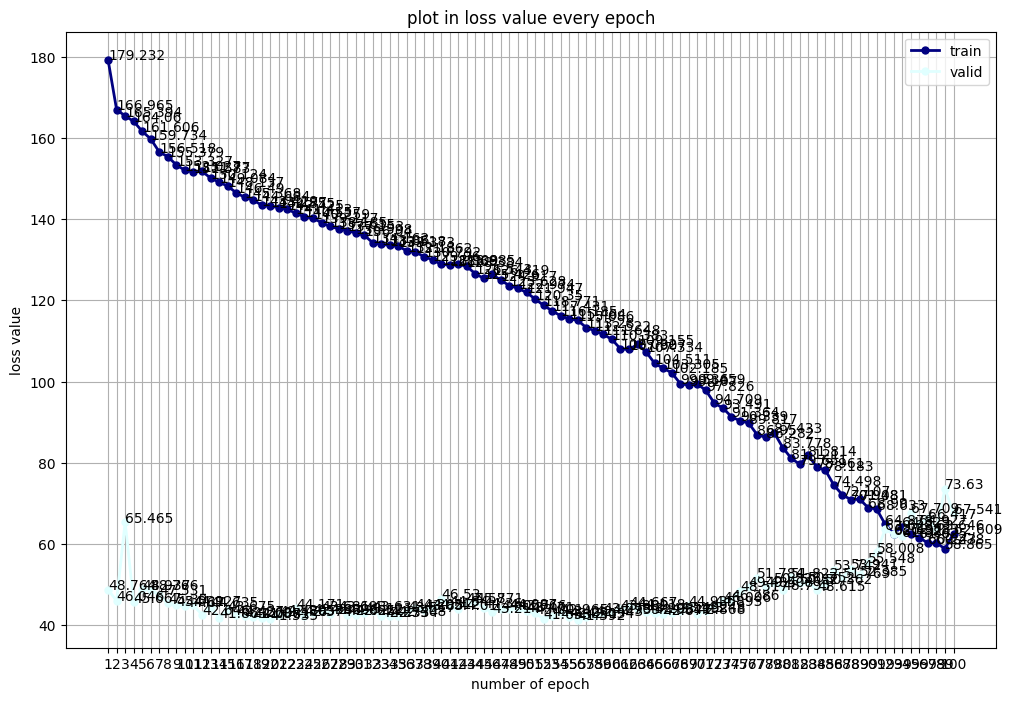

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
for i, y_datas in enumerate(y_datas_list):
    axes.plot(x_datas,
              y_datas,
              c=label2color[i],
              label=labels[i],
              marker="o",
              markersize=5,
              linestyle="solid",
              linewidth=2)
    for j in range(len(y_datas)):
        axes.annotate(text=round(y_datas[j], 3),
                      xy=(x_datas[j], y_datas[j]))
    axes.legend()
plt.title("plot in loss value every epoch")
plt.xlabel("number of epoch")
plt.ylabel("loss value")
plt.xticks(ticks=x_datas)
plt.grid(True)
plt.show()

**検証**

In [ ]:
nn_model.eval()
predict_array_list = []  # ミニバッチ毎の予測結果arrayを一時的に保管するリスト
answer_original_array_list = []  # ミニバッチ毎の正解オリジナル画像arrayを一時的に保管するリスト
answer_segment_array_list = []  # ミニバッチ毎の正解セグメント画像arrayを一時的に保管するリスト
if os.path.isfile("./FineTuning_U-Net.model"):
    nn_model.load_state_dict(torch.load("./FineTuning_U-Net.model"))
with torch.no_grad():
    epoch_valid_loss_total = 0
    for valid_original_tensor_minibatch, valid_segment_tensor_minibatch in tqdm.notebook.tqdm(valid_dataset_dataloader):
        valid_original_tensor_minibatch = valid_original_tensor_minibatch.to(device)
        valid_segment_tensor_minibatch = valid_segment_tensor_minibatch.to(device)
        predict = nn_model(in_data=valid_original_tensor_minibatch)
        print("予測結果の形状", predict.shape)
        predict_ch_softmax = torch.nn.functional.softmax(predict, dim=1)  # チャンネルの軸にsoftmaxを行って、ミニバッチ毎にピクセル値単位で全チャンネルの合計が1.0になるようにする
        print("softmax後の形状", predict_ch_softmax.shape)
        predict_ch_softmax_ch_argmax = torch.argmax(predict_ch_softmax, dim=1)  # チャンネルの軸にargmaxを行って、ミニバッチ毎にピクセル値単位で最大値のチャンネル要素を取得する
        print("argmax後の形状", predict_ch_softmax_ch_argmax.shape)
        predict_array = predict_ch_softmax_ch_argmax.detach().cpu().numpy()  # 予測結果tensorの微分を外して、cpuに移して、array化
        predict_array_list.append(predict_array)  # ミニバッチ毎の予測結果arrayを保管
        answer_original_array = valid_original_tensor_minibatch.detach().cpu().numpy()  # 正解オリジナル画像tensorの微分を外して、cpuに移して、array化
        answer_original_array_list.append(answer_original_array)  # ミニバッチ毎の正解オリジナル画像arrayを保管
        answer_segment_array = valid_segment_tensor_minibatch.detach().cpu().numpy()  # 正解セグメント画像tensorの微分を外して、cpuに移して、array化
        answer_segment_array_list.append(answer_segment_array)  # ミニバッチ毎の正解セグメント画像arrayを保管
    predict_array_all = np.concatenate(predict_array_list, axis=0)  # 予測結果arrayをチャンネルの軸でコンカチして1つに纏める
    predict_array_all = predict_array_all.astype(np.uint8)  # 値をuint8型に変換
    print(predict_array_all.shape)
    answer_original_array_all = np.concatenate(answer_original_array_list, axis=0)  # 正解オリジナル画像arrayをチャンネルの軸でコンカチして1つに纏める
    answer_original_denormalize_array_all = answer_original_array_all * 255  # 255を掛けて正規化を戻す
    answer_original_PIL_array_all = answer_original_denormalize_array_all.transpose(0, 2, 3, 1)  # PIL画像で開けるように形状を(ミニバッチ, 縦, 横, チャンネル)に変換
    answer_original_PIL_array_all = answer_original_PIL_array_all.astype(np.uint8)  # 値をuint8型に変換
    print(answer_original_PIL_array_all.shape)
    answer_segment_array_all = np.concatenate(answer_segment_array_list, axis=0)  # 正解セグメント画像arrayをチャンネルの軸でコンカチして1つに纏める
    answer_segment_array_all = answer_segment_array_all.astype(np.uint8)  # 値をuint8型に変換
    print(answer_segment_array_all.shape)

In [ ]:
answer_original_image = PIL.Image.fromarray(answer_original_PIL_array_all[0], mode="RGB")  # 0番目要素の正解オリジナル画像を取得
IPython.display.display(answer_original_image)

In [ ]:
answer_segment_image = PIL.Image.fromarray(answer_segment_array_all[0], mode="P")  # 0番目要素の正解セグメント画像を取得
answer_segment_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(answer_segment_image)

100epoch学習後の推測結果

In [ ]:
predict_image = PIL.Image.fromarray(predict_array_all[0], mode="P")  # 0番目要素の予測結果を取得
predict_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(predict_image)

90epoch学習後の推測結果

In [ ]:
predict_image = PIL.Image.fromarray(predict_array_all[0], mode="P")  # 0番目要素の予測結果を取得
predict_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(predict_image)

80epoch学習後の推測結果

In [ ]:
predict_image = PIL.Image.fromarray(predict_array_all[0], mode="P")  # 0番目要素の予測結果を取得
predict_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(predict_image)

70epoch学習後の推測結果

In [ ]:
predict_image = PIL.Image.fromarray(predict_array_all[0], mode="P")  # 0番目要素の予測結果を取得
predict_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(predict_image)

60epoch学習後の推測結果

In [ ]:
predict_image = PIL.Image.fromarray(predict_array_all[0], mode="P")  # 0番目要素の予測結果を取得
predict_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(predict_image)

50epoch学習後の推測結果

In [ ]:
predict_image = PIL.Image.fromarray(predict_array_all[0], mode="P")  # 0番目要素の予測結果を取得
predict_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(predict_image)

40epoch学習後の推測結果

In [ ]:
predict_image = PIL.Image.fromarray(predict_array_all[0], mode="P")  # 0番目要素の予測結果を取得
predict_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(predict_image)

30epoch学習後の推測結果

In [ ]:
predict_image = PIL.Image.fromarray(predict_array_all[0], mode="P")  # 0番目要素の予測結果を取得
predict_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(predict_image)

20epoch学習後の推測結果

In [ ]:
predict_image = PIL.Image.fromarray(predict_array_all[0], mode="P")  # 0番目要素の予測結果を取得
predict_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(predict_image)

10epoch学習後の推測結果

In [ ]:
predict_image = PIL.Image.fromarray(predict_array_all[0], mode="P")  # 0番目要素の予測結果を取得
predict_image.putpalette(segment_image_PIL.getpalette())  # 元のインデックスカラーのカラーパレットを設定
IPython.display.display(predict_image)